## 金融市场与量化交易大作业

组员：许京禹-201800820151，刘润洲-201800820110，黄河源-201800820087

选题：统计套利

统计套利，其核心思想是找到模式相匹配的两支股票，通过价差的变动来决定投资策略，进而获利。下面，将以具体的例子来解释如何进行统计套利。

首先，我们选取上证股票里五支航空领域的股票，时间范围为2020年10月1日到2021年1月1日，然后对其进行数据处理，画图。

(60,)
(60,)
(60,)
(60,)
(60,)


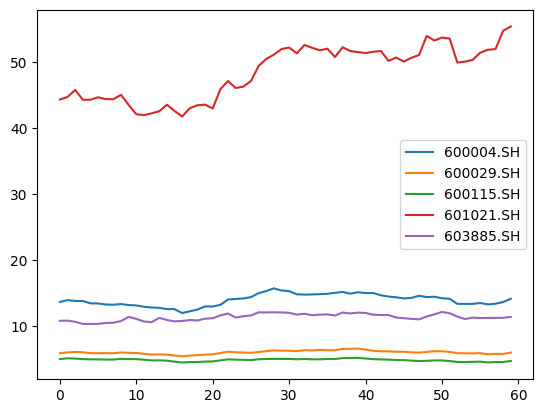

In [1]:
import backtrader as bt
import pandas as pd
import numpy as np
import quantmind as qm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

#ids=['600021.SH','600023.SH','600025.SH','600026.SH','600101.SH'] #电力
#ids = ['600017.SH','600018.SH'] #港口
ids = ['600004.SH','600029.SH','600115.SH','601021.SH','603885.SH'] #航空
start_date = '20201001'
end_date = '20210101'
param = 'close'
def process_data(ids,start,end,param):
    close_list = []
    for idx in ids:
        df = qm.get_bar(idx, start_date=start, end_date=end, freq='1d').sort_values(by="trade_date", ascending=True)
        print(df[param].values.shape)
        close_list.append(df[param].values)
    
    close_list = np.array(close_list)
    close_list = close_list.T
    ds = pd.DataFrame(data=close_list, columns=ids)
    return ds

ds = process_data(ids,start_date,end_date,param)
ds.plot()
plt.show()

由图我们可以看出，这五支股票中有几支股票似乎具有相关性，因此我们用数学方法计算这五支股票各自的相关性大小。

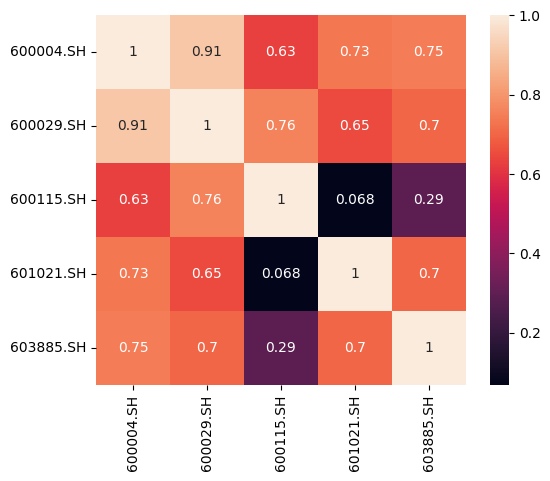

In [2]:
import seaborn as sns
# 相关性矩阵
sns.heatmap(ds.corr(), annot=True, square=True)
plt.show()

可以看到，600029和600004这两支股票的相关性系数超过了0.9，因此，我们选取这两支股票做进一步的验证。

在计算完相关性后，我们计算这两支股票的平稳性。

In [3]:
from statsmodels.tsa.stattools import adfuller
# 平稳性检验

print(adfuller(ds['600029.SH']))
print(adfuller(ds['600004.SH']))

(-1.8774390141035382, 0.34274779436717656, 1, 58, {'1%': -3.548493559596539, '5%': -2.912836594776334, '10%': -2.594129155766944}, -80.61869545249863)
(-2.074558055564997, 0.25486720888928904, 4, 55, {'1%': -3.5552728880540942, '5%': -2.9157312396694217, '10%': -2.5956695041322315}, 15.90916676270787)


可以看到，这两支股票的p值均大于0.05，因此无法拒绝不平稳的原假设。所以，我们对这两支股票做一阶差分，再查看这两支股票的平稳性。

In [4]:
# 一阶差分
A = np.diff(ds['600029.SH'])
B = np.diff(ds['600004.SH'])
print(adfuller(A))
print(adfuller(B))

(-5.797158300098492, 4.722647769573928e-07, 0, 58, {'1%': -3.548493559596539, '5%': -2.912836594776334, '10%': -2.594129155766944}, -77.19378548126443)
(-3.383478397662051, 0.011535152577418011, 1, 57, {'1%': -3.5506699942762414, '5%': -2.913766394626147, '10%': -2.5946240473991997}, 19.082621348496957)


一阶差分后，两支股票都趋于平稳，因此二者是同阶单整的。所以，我们再做协整检验。

In [5]:
from statsmodels.tsa.stattools import coint
# 协整检验
print(coint(ds['600029.SH'], ds['600004.SH']))

(-3.465310945757645, 0.03559690018626509, array([-4.09169685, -3.44165109, -3.11711613]))


可以发现，检验的p值小于0.05，因此说明这两支股票具有协整关系。因此，我们选取这两支股票进行匹配，作为我们统计套利的对象。

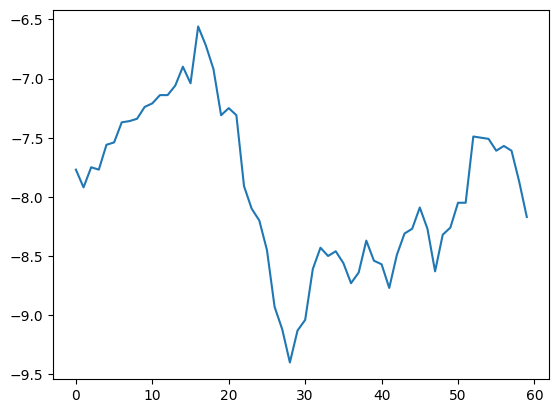

In [6]:
data = ds['600029.SH']- ds['600004.SH']
data.plot()
plt.show()

由于二者存在协整关系，因此，我们可以近似认为二者的价差满足正态分布，也就是说，二者的价差会围绕一个均值进行波动。因此，设两支股票为A，B，价差为A-B，价差均值为μ，价差标准差为σ，我们可以有如下策略：

- 当价差高于μ一个σ时，卖出A，买入B；
- 当价差低于μ一个σ时，卖出B，买入A。

我们可以画图展示。

(60,)
(60,)
(60,)
(60,)
(60,)


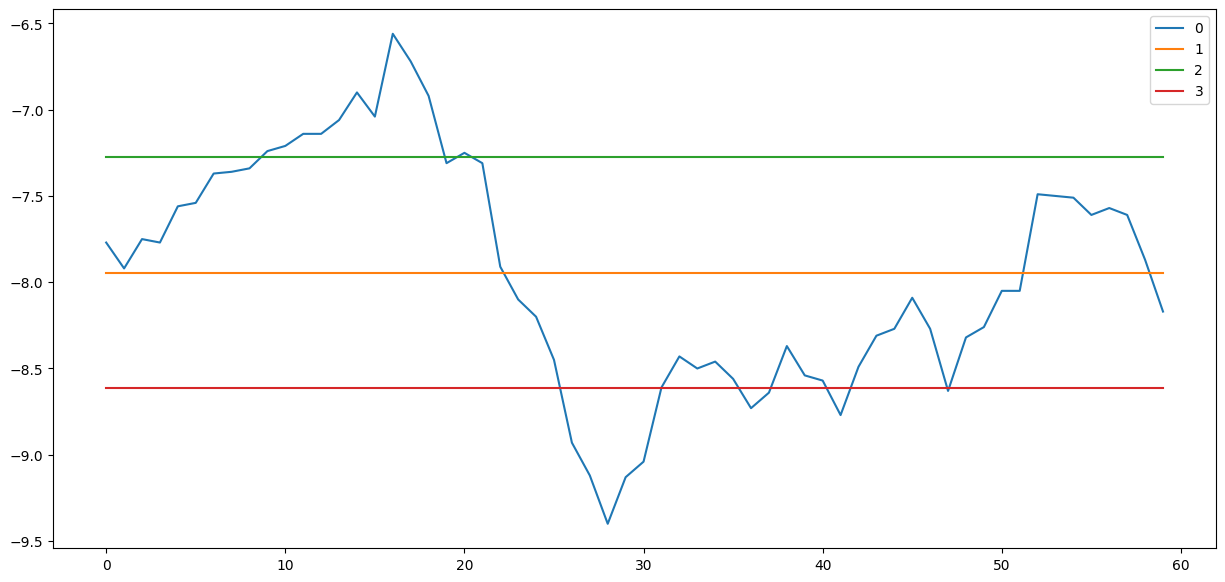

In [7]:
ds = process_data(ids,start_date,'20210101',param)
diff = ds['600029.SH'] - ds['600004.SH']
mean=np.mean(diff)
std=np.std(diff,ddof=1)
up=mean+std
down=mean-std
time=diff.index
mean_line=pd.Series(mean,index=time)
up_line=pd.Series(up,index=time)
down_line=pd.Series(down,index=time)

set=pd.concat([diff,mean_line,up_line,down_line],axis=1)
set.plot(figsize=(15,7))
plt.show()

但是，由于股票市场存在较多不确定因素，因此无法保证选取的两支股票能一直满足匹配的条件。因此，我们还需要加入一个预警机制，一旦出现异常值，就重新进行匹配和建模。具体方式如下：

- 如果价差与均值的差值绝对值超过了2σ，则认为出现异常值，需要重新进行匹配和建模。

选取2σ的原因是：如果认为价差满足正态分布，则价差的值有大约95%的概率落在\[μ-2σ,μ+2σ\]里，超过这个范围是一个极小的概率事件。因此我们可以认为一旦价差超过该区间，则说明模型很可能失效，需要重新建模。

将以上策略总结，结合backtrader具体应用如下：

In [8]:
import backtrader as bt
import pandas as pd
import numpy as np
import quantmind as qm
import statsmodels.api as sm

ids = ['600004.SH','600029.SH','600115.SH','601021.SH','603885.SH']
class TestStrategy(bt.Strategy):
    ##初始化函数，用初始化属性、计算指标等
    def __init__(self):
        self.data_list = []
        self.model_init = False
        for i in range(5):
            self.data_list.append(self.datas[i].close)
        self.mean = None
        self.std = None
        self.A = None
        self.B = None
        self.best_pair = None

    def log(self, arg):
        #打印日志函数，要有这个其他的self.log()才能正常显示
        print('{} {}'.format(self.datetime.date(), arg))

    #必选函数，交易的逻辑都在这一部分中
    def next(self):
        # 获取五支股票60天的信息
        list_1 = self.data_list[0].get(ago=0,size=60)
        list_2 = self.data_list[1].get(ago=0,size=60)
        list_3 = self.data_list[2].get(ago=0,size=60)
        list_4 = self.data_list[3].get(ago=0,size=60)
        list_5 = self.data_list[4].get(ago=0,size=60)
        list_1 = np.array(list_1)
        list_2 = np.array(list_2)
        list_3 = np.array(list_3)
        list_4 = np.array(list_4)
        list_5 = np.array(list_5)
        
        pair_list = []
        # 根据相关性，确定候选的匹配对象
        if len(list_1)==60:
            list_1 = list_1.reshape((60,1))
            list_2 = list_2.reshape((60,1))
            list_3 = list_3.reshape((60,1))
            list_4 = list_4.reshape((60,1))
            list_5 = list_5.reshape((60,1))
            all_data = np.concatenate((list_1,list_2,list_3,list_4,list_5),axis=1)
            if self.model_init == False:
                df2 = pd.DataFrame(all_data)
                cor = df2.corr().values
                lowest_cor = 0.9
                for i in range(4):
                    for j in range(i+1,5):
                        if cor[i,j]>lowest_cor:
                            pair_list.append((i,j,cor[i,j]))
            #self.log(pair_list)
        
        best_cor = 0
        
        # 计算是否满足协整关系
        if len(pair_list) != 0 and self.model_init == False:
            for pair in pair_list:
                A = np.diff(all_data[:,pair[0]])
                B = np.diff(all_data[:,pair[1]])
                a = adfuller(A)[1]
                b = adfuller(B)[1]
                my_coint = coint(all_data[:,pair[0]],all_data[:,pair[1]])[1]
                if a<0.05 and b<0.05 and my_coint<0.05:
                    if pair[2]>best_cor:
                        best_cor = pair[2]
                        self.best_pair = pair
            # 选取两支匹配的股票
            if self.best_pair != None:
                self.model_init = True
                self.A = all_data[:,self.best_pair[0]]
                self.B = all_data[:,self.best_pair[1]]
                
                self.mean = np.mean(self.A - self.B)
                self.std = np.std(self.A-self.B,ddof=1)
                self.log("A:{0}".format(ids[self.best_pair[0]]))
                self.log("B:{0}".format(ids[self.best_pair[1]]))
                
                
        
        # 构建模型
        if self.model_init == True:
            self.A = all_data[:,self.best_pair[0]]
            self.B = all_data[:,self.best_pair[1]]
            diff = self.datas[self.best_pair[0]].close[0] - self.datas[self.best_pair[1]].close[0] #价差
            
            # self.log(diff)
            uncer = diff - self.mean
            #根据价差与std和mean的关系，做出买入、卖出的决策
            if uncer>=self.std and uncer<2*self.std:
                if self.getposition(self.datas[self.best_pair[0]]).size >0:
                    self.log('SELL CREATE A, %.2f' % self.datas[self.best_pair[0]].close[0])
                    self.order = self.sell(data=self.datas[self.best_pair[0]],size=self.getposition(self.datas[self.best_pair[0]]).size)
                if self.getposition(self.datas[self.best_pair[1]]).size == 0:
                    self.log('BUY CREATE B, %.2f' % self.datas[self.best_pair[1]].close[0])
                    self.order = self.buy(data=self.datas[self.best_pair[1]],size=2000)
            elif -uncer>= self.std and -uncer<2*self.std:
                if self.getposition(self.datas[self.best_pair[1]]).size >0:
                    self.log('SELL CREATE B, %.2f' % self.datas[self.best_pair[1]].close[0])
                    self.order = self.sell(data=self.datas[self.best_pair[1]],size=self.getposition(self.datas[self.best_pair[1]]).size)
                if self.getposition(self.datas[self.best_pair[0]]).size == 0:
                    self.log('BUY CREATE A, %.2f' % self.datas[self.best_pair[0]].close[0])
                    self.order = self.buy(data=self.datas[self.best_pair[0]],size=2000)
            # 预警机制，一旦超出正常范围则重新匹配和建模
            elif np.abs(uncer)>=2*self.std:
                if self.getposition(self.datas[self.best_pair[1]]).size >0:
                    self.log('SELL CREATE B, %.2f' % self.datas[self.best_pair[1]].close[0])
                    self.order = self.sell(data=self.datas[self.best_pair[1]],size=self.getposition(self.datas[self.best_pair[1]]).size)
                if self.getposition(self.datas[self.best_pair[0]]).size >0:
                    self.log('SELL CREATE A, %.2f' % self.datas[self.best_pair[0]].close[0])
                    self.order = self.sell(data=self.datas[self.best_pair[0]],size=self.getposition(self.datas[self.best_pair[0]]).size)
                self.log("change the model")
                self.model_init = False
                
                
if __name__ == '__main__':
    start = '20200101'
    end = '20211213'
    # 实例化：创建一个大脑
    cerebro = bt.Cerebro()
    # 读取数据
    ids = ['600004.SH','600029.SH','600115.SH','601021.SH','603885.SH'] #航空
    for my_id in ids:
        df = qm.get_bar(my_id, start_date=start, end_date=end, freq='1d').sort_values(by="trade_date", ascending=True)
        df['trade_date1'] = pd.to_datetime(df['trade_date'],format="%Y%m%d")
        data = bt.feeds.PandasData(
            dataname=df,
            datetime = 'trade_date1',
            open=3,
            high=4,
            low=5,
            close=6,
            volume=7,
            openinterest=-1,
            timeframe=bt.TimeFrame.Days,
            )
        cerebro.adddata(data, name=my_id)
   
   
    # 添加一个策略
    cerebro.addstrategy(TestStrategy)
    
    # 设置初始资金
    cerebro.broker.setcash(100000.0)
    cerebro.broker.setcommission(commission=0.00018)
    
    cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='AnnualReturn')
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='SharpeRatio')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='DrawDown')
    
    # 打印初始资金
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())   
   
    # 运行所有程序
    test = cerebro.run()
    # 打印最终结果
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

    strat = test[0]
    # 打印评价指标
   
    print(strat.analyzers.AnnualReturn.get_analysis())  
    print(strat.analyzers.SharpeRatio.get_analysis()) 
    print(strat.analyzers.DrawDown.get_analysis())

Starting Portfolio Value: 100000.00
2020-04-02 A:600029.SH
2020-04-02 B:600115.SH
2020-04-02 BUY CREATE A, 5.18
2020-04-13 SELL CREATE A, 5.14
2020-04-13 change the model
2020-04-14 A:600115.SH
2020-04-14 B:603885.SH
2020-04-14 BUY CREATE B, 9.31
2021-02-24 SELL CREATE B, 13.22
2021-02-24 BUY CREATE A, 4.91
2021-03-11 SELL CREATE A, 5.02
2021-03-11 change the model
2021-03-12 A:600115.SH
2021-03-12 B:603885.SH
2021-03-12 change the model
2021-03-15 A:600115.SH
2021-03-15 B:603885.SH
2021-03-15 change the model
2021-03-16 A:600115.SH
2021-03-16 B:603885.SH
2021-03-16 change the model
2021-03-17 A:600115.SH
2021-03-17 B:603885.SH
2021-03-17 change the model
2021-03-18 A:600115.SH
2021-03-18 B:603885.SH
2021-03-18 change the model
2021-03-19 A:600115.SH
2021-03-19 B:603885.SH
2021-03-19 change the model
2021-03-22 A:600115.SH
2021-03-22 B:603885.SH
2021-03-22 BUY CREATE A, 5.57
2021-04-21 SELL CREATE A, 5.62
2021-04-21 change the model
2021-04-22 A:600115.SH
2021-04-22 B:603885.SH
2021-05

由上述结果可知，按照设定的统计套利的策略，起始资金100000元，最终净利润为8973.94元，两年的年利率都在4%以上，收益较好。